# Sinusoidal Curve Fitting

A friend recently asked for some help in thinking about programming a curve fitting tool for sinusoidal data. Things like the position as a function of time of a mass on a spring, for example.

In this post I want to explore three different approaches:

1. `NonlinearModelFit` in the Wolfram Engine (so a powerful nonlinear curve fitting tool)
2. Using a Fast Fourier Transform (FFT) to pick out the dominant frequency
3. Using a "find the peak" approach of the value of the fourier integrals

First let's make some slightly noisy data that we can use for all three:

-Graphics-
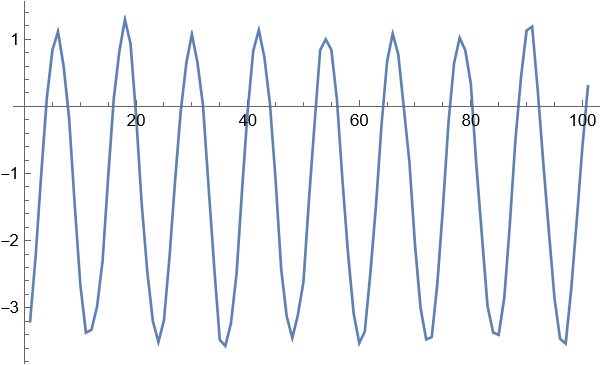

In [3]:
targetAmplitude=2.3;
targetOmega=5.2;
targetPhase=-2.5;
targetOffset=-1.2;
data=Table[targetAmplitude Cos[targetOmega t+targetPhase]+targetOffset+Random[NormalDistribution[0,0.1]],{t,0,10,.1}];
ListLinePlot[data]

I think for all three it'll be easiest to quickly get a measure of the offset and just shift the data by that much:

In [9]:
mean=Mean[data]
data=data-mean;

-1.22582

Not bad compared to the targetOffset:

In [12]:
Abs[targetOffset-mean]/Abs[targetOffset]

0.0215178

or a 2% error

# `NonlinearModelFit`

First we'll use the Wolfram Engine's workhorse for this sort of thing. However, we'll have to modify the data so that each data point also has an associated time:

In [13]:
nlmData=Table[{(i-1) 0.1, data[[i]]},{i,Length[data]}];

NonlinearModelFit::cvmit: Failed to converge to the requested accuracy or precision within 100 iterations.

FittedModel[Panel[-76.0715 + 76.1422 Cos[0.00110365 + 0.00727639 t], FrameMargins -> 5]]
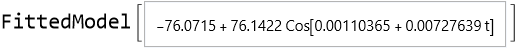

In [15]:
nlm=NonlinearModelFit[nlmData,A Cos[omega t+phi]+offset, {A,omega,phi,offset},t]

This is really bad, and it's almost certainly because we didn't give it any initial guesses for any of the four parameters. In my experience, it really only needs a good one for the omega (frequency):

FittedModel[Panel[0.00479454 + 2.30788 Cos[2.49598 - 5.19962 t], FrameMargins -> 5]]
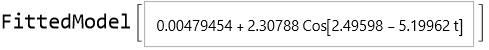

In [44]:
nlm=NonlinearModelFit[nlmData, A Cos[omega t+phi]+offset, {{A,2.}, {omega,5.0}, {phi,-2.0}, {offset,0}},t]

What's cool about that is you can read off the parameters just from the equation. But you can also access them:

Estimate     Standard Error   t‐Statistic   P‐Value

                                                               -123
A        2.30788      0.0130107        177.383       1.14105 10

                                                               -239
omega    5.19962      0.0018771        2770.03       2.21145 10

                                                               -134
phi      -2.49598     0.0109201        -228.568      2.52779 10

offset   0.00479454   0.00913763       0.524703      0.600987
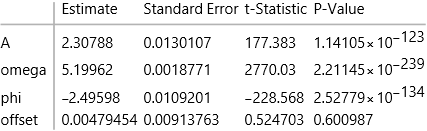

In [45]:
nlm["ParameterTable"]

In [21]:
targetAmplitude
targetOmega
targetPhase

2.3
5.2
-2.5

-Graphics-
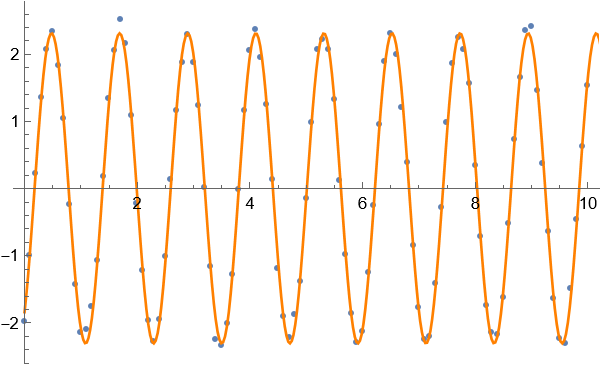

In [46]:
Show[ListPlot[nlmData],Plot[nlm[t],{t,0,100},PlotStyle->Orange]]

That's pretty good, but it was remarkable how close I had to be with the initial guesses to get that good of a result. That's actually one of the biggest hassles with sinusoidal fitting (google it, you'll see my point).

## Fast Fourier Transform

The Fast Fourier Transform (FFT) is really a cool tool. It's a really fast way to find the frequency structure of any signal, and what's remarkable about it is that it totally nails your data. It's not like a partial fit, it nails your data perfectly as a collection of sinusoidal terms. 

If you feed it data that's basically just a (noisy) single sine wave, it should give you a mostly empty result with all the amplitude in just one peak. That's what would happen with an audio spectrum analyser if you whistled into it, for example.

One fascinating thing about the FFT algorithm is that to make it as fast as possible, it structures the results in a weird way. Since we'll be using real (as in, not imaginary) data, that means that all the useful data is in the first half of the result, with the second half being just the complex conjugate of the first half (and in reverse!). So I really just grab data from the first half.

-Graphics-
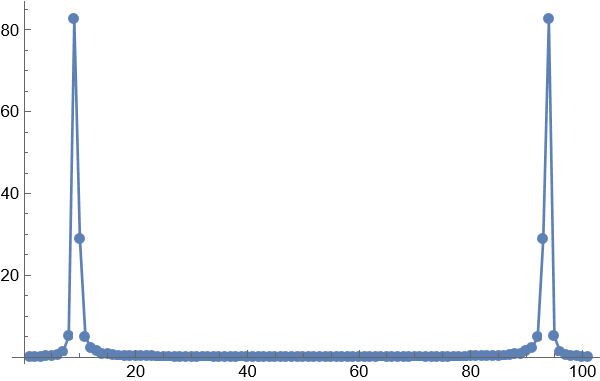

In [51]:
fft=Fourier[data];
ListLinePlot[Abs[fft]^2,PlotRange->All, PlotMarkers->Automatic] (* this shows the power specturm by squaring the result *)

Hmmm, it's not just one peak (again, ignore the second half, it's just a mirrored image). That peak is really a fair amount of energy from 2-4 different frequencies. What we essentially have is:

$$f(t)=\sum_i^N A_i e^{i\omega_i t}$$

The reason the fft is saying we have multiple frequencies is that the frequency of our data does not land in one of the frequencies it's using ($\omega_i$) which is given by $\omega_i=i \frac{2\pi}{N\,dt}$ where i is the bin count of output (i=0 is the DC offset which we subtracted out above, then i=1 is for the energy at $2\pi/N\,dt$, and so on). Those are all evenly spaced frequencies and the chances are that your underlying frequency for your data doesn't land exactly on one of the bins.

I think a good way to do this is to do a weighted average of the FFT results by the "energy" of each one, which we can approximate as the magnitude squared of the associated amplitude. Let's see what we get if we do that:

In [62]:
bestFreq=Total[Table[Abs[fft[[i]]]^2 (i-1) 2 Pi/10, {i,1,20}]]/Total[Table[Abs[fft[[i]]]^2,{i,1,20}]]

5.31842

In [58]:
FindPeaks[Abs[fft]^2]

{{9, 82.5555}, {22, 0.264919}, {32, 0.126481}, {39, 0.0989271}, {42, 0.0755395}, 
 
>   {45, 0.0663455}, {48, 0.0728359}, {55, 0.0728359}, {58, 0.0663455}, {61, 0.0755395}, 
 
>   {64, 0.0989271}, {71, 0.126481}, {81, 0.264919}, {94, 82.5555}}

In [68]:
Total[fft[[7;;10]]]

0.739392 + 7.0913 I

-Graphics-
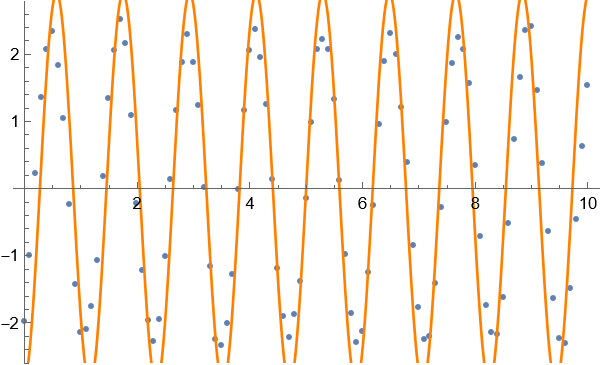

In [109]:
Show[ListPlot[nlmData],Plot[Re[Total[fft[[1;;20]]] Exp[-I bestFreq t] ],{t,0,10},PlotStyle->Orange]]

hmmm. This isn't great. Having read [this page](http://www.nicholson.com/rhn/dsp.html#1) I'm now convinced that this approach is pretty subtle to get right. 

## Maximize the Fourier integrals

The Fourier theorem suggests that any function `f(t)` can be thought of as the sum of a bunch of sine and cosine waves. For a finite time window, the theory says that you can find the amount of a collection of sinusoidal waves that add up to your original function. The amount for the cosine and sine components are given by:

$$\text{cosine part}\propto \int \cos(\omega t) f(t)\,dt$$
$$\text{sine part}\propto \int \sin(\omega t) f(t)\,dt$$

Where you just have to plug in the $\omega$. For this approach I figured that the squared sum of those two should be maximized for the right frequency if `f(t)` really is just a noisy sinusoidal wave. Instead of integrals I'll just sample the sine and cosine waves of that frequency at the same rate as my data then, point by point, multiply them with the data point at that time and sum. Really that just turns out to be a dot product.

-Graphics-
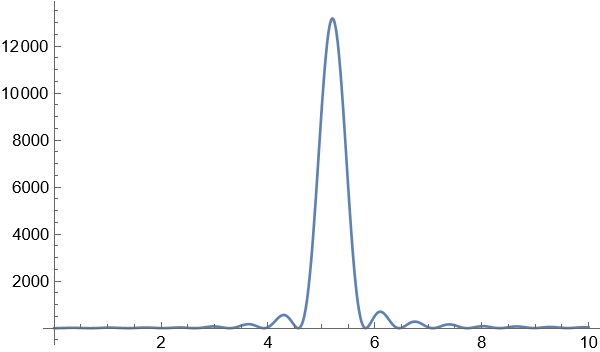

In [118]:
cosinePart[omega_?NumericQ]:=Table[Cos[omega t],{t,0,10,.1}].data;
sinePart[omega_?NumericQ]:=Table[Sin[omega t], {t,0, 10, .1}].data;
energy[omega_?NumericQ]:=cosinePart[omega]^2+sinePart[omega]^2;
Plot[energy[omega],{omega,0,10},PlotRange->All]

It's a pretty smooth function with a clear peak. Let's see how sensitive Wolfram's `FindMaximum` is to initial conditions:

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

General::stop: Further output of FindMaximum::lstol will be suppressed during this calculation.

{{15.4875, {omega -> 0.345047}}, {22.5047, {omega -> 1.03976}}, 
 
>   {22.5047, {omega -> 1.03976}}, {72.9572, {omega -> 2.98578}}, 
 
>   {72.062, {omega -> 8.65367}}, {13175.2, {omega -> 5.2075}}, 
 
>   {700.944, {omega -> 6.10233}}, {13175.2, {omega -> 5.2075}}, 
 
>   {83.9599, {omega -> 8.02375}}, {16.9562, {omega -> 13.6862}}, 
 
>   {37.9403, {omega -> 9.90158}}}
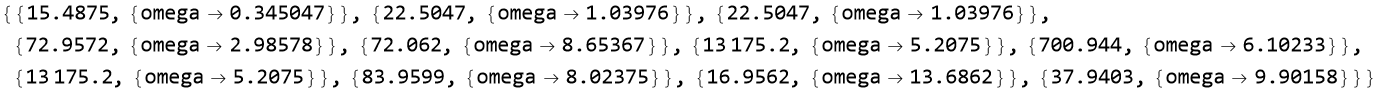

In [122]:
Table[FindMaximum[energy[omega], {omega,omegaStart}], {omegaStart,0,10,1}]

Hmmm. only two of these actually get the right answer (remember that the targetOmega is 5.2). Those were for guesses of 5 and 7. Oddly a guess of 6 converged to the wrong answer.

In [123]:
targetOmega

5.2

Note that the Wolfram Engine has a function that looks for a true global maximum. It works just fine (but since I'm trying to help a friend who can't make use of the Wolfram Engine, it's not really a solution I can use):

In [141]:
NMaximize[energy[omega],omega]

{13175.2, {omega -> 5.2075}}

I suppose you could just run it for a bunch of initial guesses and find the biggest peak:

In [134]:
best={-1,-1000};
Table[{peakSize, omegaMap}=FindMaximum[energy[omega], {omega,omegaStart}];
    If[peakSize>best[[1]], best={peakSize, omega/.omegaMap}], {omegaStart,0,10}];
best

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

General::stop: Further output of FindMaximum::lstol will be suppressed during this calculation.

{13175.2, 5.2075}

-Graphics-
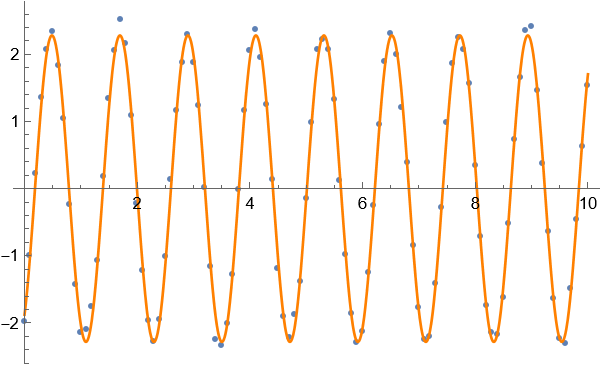

In [139]:
scaleFactor=(tmp=Table[Cos[best[[2]] t], {t,0,10,.1}]).tmp;
Show[ListPlot[nlmData],Plot[(cosinePart[best[[2]]] Cos[best[[2]] t]+sinePart[best[[2]]] Sin[best[[2]] t])/scaleFactor, {t,0,10},PlotStyle->Orange]]

Works pretty well! How did I find that scale factor? Well, note in the equations above I was pretty lazy with the proportionality constant, but given how we're doing dot products here, my guess was that each was going to be too big by the integrated sum of the cosine or sine functions themselves. In a normal integral situation, cosine squared and sine squared integrate to one half the time range, but by doing the `tmp.tmp` that I'm doing up there it's effectively doing that.

## Final thoughts

So I think the third way is likely the easiest to do in an environment when you don't have easy access to things like the Wolfram Engine or python's numpy library. You just have to run a bunch of dot products and do local maximization (that's relatively straightforward) and repeat over a large range until you find a global maximum. You could also program a more subtle global peak finder, but likely this approach would be fast enough.

## Your thoughts?

I'd love to hear from you. Here are some starters for you:

1. Why aren't you naming your friend? Is it President Biden, by any chance?
2. This is great. What I especially like is . . .
3. This is dumb. You really don't know how to google things, do you?
4. I thought you hated cosine.
5. Why don't you like how the FFT orders its results? I think it's beautiful!
6. How would you calculate an $R^2$ value for the second and third approaches?